In [1]:
import silq
silq.initialize('Antimony')
layout.acquisition_outputs([('arbstudio.ch3', 'output')])
from silq.parameters import DCSweepParameter
%matplotlib notebook

Initializing imports
Initializing functions
Initializing instruments
Initializing parameters
Initializing data
Initialization complete


# 2D Auto update

<IPython.core.display.Javascript object>


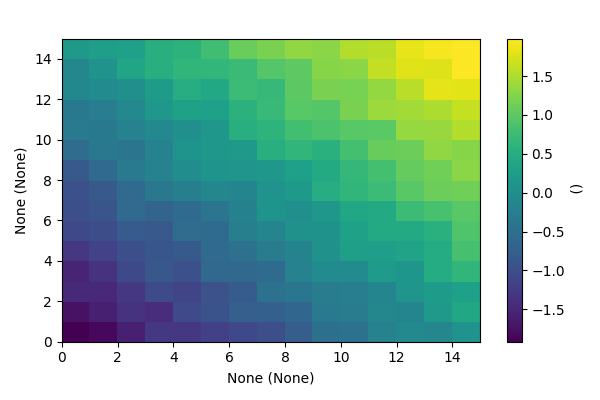

In [4]:
plot = DCSweepPlot(DC_sweep_parameter, auto_start=True)

In [5]:
plot.start()

In [5]:
plot.stop()

## DC sweep plot

In [3]:
from silq.tools.plot_tools import *
class DCSweepPlot(InteractivePlot):
    def __init__(self, parameter, interval=0.5, auto_start=False):
        super().__init__(subplots=1)
        self.layout = station.layout

        self.parameter = parameter

        if auto_start:
            self.parameter.setup(start=True)

        if self.parameter.results is None:
            if auto_start:
                self.parameter.acquire(start=False, stop=False)
            else:
                self.parameter()
        self.add(self.parameter.results)

        self.timer = self.fig.canvas.new_timer(interval=interval * 1000)
        self.timer.add_callback(self.rescan, self[0])

        if auto_start:
            self.start(setup=False)

    def random_data(self, shape=(10, 10)):
        return np.random.randint(0, 10, size=shape)

    @property
    def interval(self):
        return self.timer.interval / 1000

    @interval.setter
    def interval(self, interval):
        if hasattr(self, 'timer'):
            self.timer.interval = interval * 1000

    def start(self, setup=True):
        if setup:
            self.parameter.setup(start=True)
        self.timer.start()

    def stop(self):
        self.timer.stop()
        self.layout.stop()

    def rescan(self, ax=None):
        if ax is None:
            ax = self[0]
        results = self.parameter.acquire(start=False, stop=False)
        noise = 0.03 * self.random_data(shape=results.shape)
        self.traces[0]['config']['z'] = results + noise
        self.update_plot()

# 2D

In [2]:
DC_sweep_parameter = DCSweepParameter()
DC_sweep_parameter.pulse_duration = 1
DC_sweep_parameter.final_delay = 100

DC_sweep_parameter.add_sweep('TGAC', np.linspace(-1, 1, 15), connection_label='arb_output')
DC_sweep_parameter.add_sweep('DF', np.linspace(-1, 1, 15), connection_label='arb_output')

print(f'pulses: {len(DC_sweep_parameter.pulse_sequence)}')

pulses: 225


In [118]:
DC_vals = DC_sweep_parameter()

In [129]:
DC_sweep_parameter.setup(start=True)
%timeit -r10 DC_vals = DC_sweep_parameter.acquire(start=False, stop=False)

1 loop, best of 10: 150 ms per loop


<IPython.core.display.Javascript object>


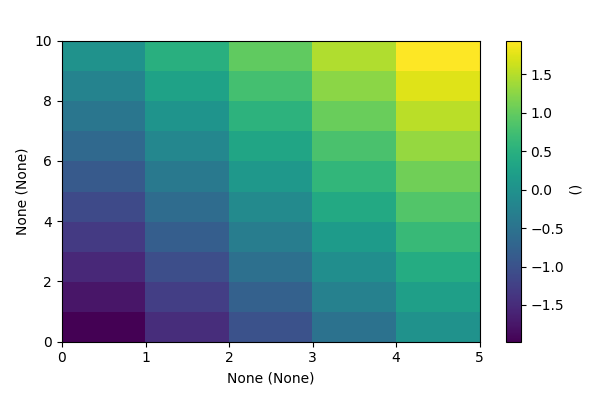

In [31]:
MatPlot(DC_vals)

# 1D

In [32]:
DC_sweep_parameter = DCSweepParameter()
DC_sweep_parameter.final_delay = 10

DC_sweep_parameter.add_sweep('arb_output', np.linspace(-1, 1, 50))

DC_sweep_parameter['arb_output'].sweep_voltages = np.linspace(-1, 1, 10)

DC_sweep_parameter.pulse_sequence

PulseSequence with 0 pulses, duration: 0

## Time single acquire

In [28]:
DC_sweep_parameter.setup()
layout.start()

In [29]:
%timeit DC_sweep_parameter.acquire(average_mode='point', start=False, stop=False)

10 loops, best of 3: 120 ms per loop


In [30]:
layout.stop()

## Time full get acquisition

Wall time: 2.85 s


<IPython.core.display.Javascript object>


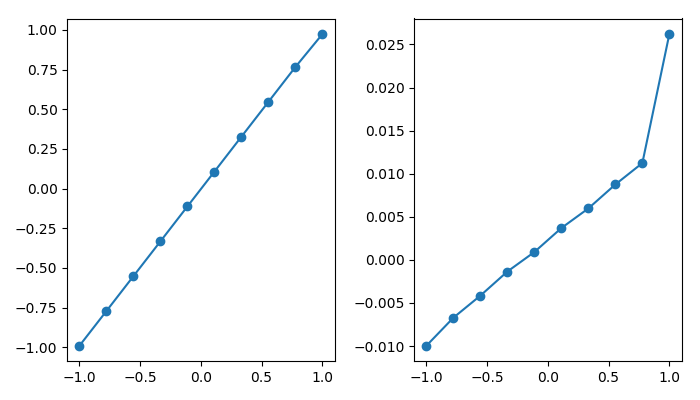

In [3]:
%time DC_vals = DC_sweep_parameter()
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
axes[0].plot(DC_sweep_parameter.setpoints[0], DC_vals, 'o-');
axes[1].plot(DC_sweep_parameter.setpoints[0], 
             np.array(DC_sweep_parameter.setpoints[0]) - DC_vals, 'o-');
plt.tight_layout()

## Looking at traces

In [5]:
DC_sweep_parameter.setup()
layout.start()

In [5]:
%time DC_sweep_parameter.acquire(average_mode='trace', start=False, stop=False)

Wall time: 141 ms


In [6]:
traces = DC_sweep_parameter.trace_segments['output']
traces = [traces[f'DC_read[{k}]'][0] for k in range(len(DC_sweep_parameter.setpoints[0]))]

<IPython.core.display.Javascript object>


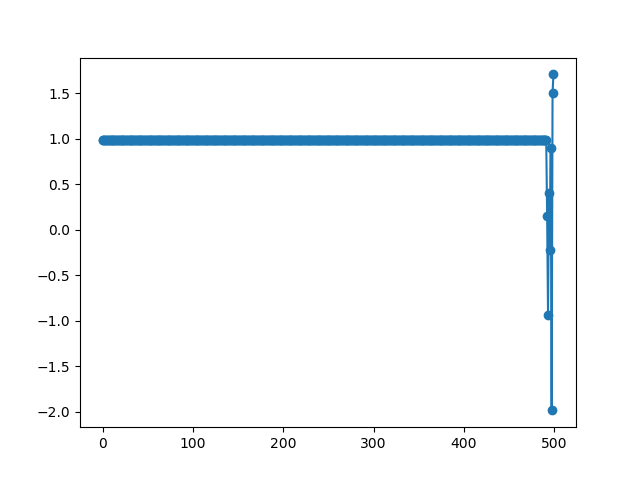

In [7]:
plt.figure()
plt.plot(traces[-1], 'o-')

# Custom DC Sweep Parameter

In [2]:
from silq.parameters import AcquisitionParameter
from silq.tools.general_tools import clear_single_settings, UpdateDotDict
from collections import OrderedDict


class DCSweepParameter(AcquisitionParameter):
    def __init__(self, **kwargs):
        super().__init__(name='DC_acquisition',
                         names=['DC_voltage'],
                         labels=['DC voltage'],
                         snapshot_value=False,
                         setpoint_names=(('None',),),
                         shapes=((1,),),
                         **kwargs)

        self.pulse_duration = 5
        self.final_delay = 10

        self.additional_pulses = []
        self.samples = 1

        self.sweep_parameters = OrderedDict()

    def __getitem__(self, item):
        return self.sweep_parameters[item]

    def add_sweep(self, parameter_name,
                  sweep_voltages=None, connection_label=None):
        if connection_label is None:
            connection_label = parameter_name

        self.sweep_parameters[parameter_name] = UpdateDotDict(
            update_function=self.generate_pulse_sequence,
            name=parameter_name,
            sweep_voltages=sweep_voltages,
            connection_label=connection_label)
        
        self.generate_pulse_sequence()

    def generate_pulse_sequence(self):
        self.pulse_sequence.clear()
        
        iter_sweep_parameters = iter(self.sweep_parameters.items())
        if len(self.sweep_parameters) == 1:
            sweep_name, sweep_dict = next(iter_sweep_parameters)
            sweep_voltages = sweep_dict.sweep_voltages
            
            pulses = [DCPulse('DC_read',
                              duration=self.pulse_duration,
                              acquire=True,
                              amplitude=sweep_voltage,
                              connection_label=sweep_dict.connection_label)
                      for sweep_voltage in sweep_voltages]
            self.pulse_sequence = PulseSequence(pulses=pulses)
#             self.pulse_sequence.add(*self.additional_pulses)

            self.setpoint_names = ((sweep_name, ), )
            self.shapes = ((len(sweep_voltages), ), )
            self.setpoints = ((sweep_voltages, ), )
        elif len(self.sweep_parameters) == 2:
            outer_sweep_name, outer_sweep_dict = next(iter_sweep_parameters)
            outer_sweep_voltages = outer_sweep_dict.sweep_voltages
            inner_sweep_name, inner_sweep_dict = next(iter_sweep_parameters)
            inner_sweep_voltages = inner_sweep_dict.sweep_voltages
            if outer_sweep_dict.connection_label == inner_sweep_dict.connection_label:
                connection_label = outer_sweep_dict.connection_label
                pulses = []
                for outer_sweep_voltage in outer_sweep_voltages:
                    for inner_sweep_voltage in inner_sweep_voltages:
                        sweep_voltage = (inner_sweep_voltage, outer_sweep_voltages)
                        
                        # TODO removeme
                        sweep_voltage = inner_sweep_voltage + outer_sweep_voltage
                        
                        pulses.append(DCPulse('DC_read',
                                              duration=self.pulse_duration,
                                              acquire=True,
                                              amplitude=sweep_voltage,
                                              connection_label=connection_label))
                self.pulse_sequence = PulseSequence(pulses=pulses)
                self.setpoint_names = ((outer_sweep_name, inner_sweep_name),),
                self.shapes = ((len(outer_sweep_voltages), len(inner_sweep_voltages), ), )
                self.setpoints = ((outer_sweep_voltages, inner_sweep_voltages), )
            else:
                raise NotImplementedError(
                    f"Cannot handle two parameters with different connection_labels")
        else:
            raise NotImplementedError(
                f"Cannot handle {len(self.sweep_parameters)} parameters")

        self.pulse_sequence.duration += self.final_delay
        
    def acquire(self, stop=False, **kwargs):
        super().acquire(average_mode='point', stop=stop, **kwargs)
        
        # Process results
        DC_voltages = np.array([self.trace_segments['output'][pulse.full_name] 
                                for pulse in self.pulse_sequence])
        if len(self.sweep_parameters) == 1:
            self.results = DC_voltages
        elif len(self.sweep_parameters) == 2:
            self.results = DC_voltages.reshape(self.shapes[0])
        else:
            raise NotImplementedError(
                f"Cannot handle {len(self.sweep_parameters)} parameters")
        
        return self.results
        
        
    @clear_single_settings
    def get(self):
        self.setup()
        self.acquire(stop=True)
        return self.results
